# Second class

## Table of Contents (times are approximated)

1. [Summary of the first class (0.5-1 h, depending on previous knowledge about OOP)](#summary)  
2. [Collaborative Filtering (~15 min)](#cf)  
   2.1 [Co-occurrence Matrix (1.5-2h)](#copurchase)
   <br></br>
   2.2 [Memory-based CF (1-1.5 h)](#memory-base)
   <br></br>
   2.3 [Model-based CF (2-2.5 h)](#model-base)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import io
import os

## Summary of the first class in code <a id='summary'></a>

Ha puesto en tres clases lo que hicimos ayer. Más ordenado. 

In [4]:
class movielens_100k(object):
    """
    This python class read the movielens-100k dataset and:
        . Preprocess train and test sets
        . Create a python dict that allows us to translate any item id to the corresponding movie title
    """
    
    def __init__(self, data_root, item_id_file='u.item', train_file='u2.base', test_file='u2.test', 
                 columns=['user_id', 'item_id', 'rating', 'timestamp']):
                
        self.data_root = data_root
        self.items_id_file = os.path.join(self.data_root, item_id_file)
        self.train_file = train_file
        self.test_file = test_file
        self.columns = columns
        self.__data = {}  # dictionary to store train and test data
            
    def __getitem__(self, dataset):
        """
        Get train and test data

        :param dataset: dataset name (String)
        :return: pandas dataframe
        """
        return self.__data[dataset]

    def __setitem__(self, key, value):
        """
        Store train and test data in the dictionary self.__data.

        :param key: name of the dataset (String)
        :param value: pandas dataframe
        """
        self.__data[key] = value
        
    def read_data(self, file, verbose=False):
        """
        Read file returning a pandas dataframe
        :param file: file path
        :param verbose: print the first rows of the data
        """
        datafile = os.path.join(self.data_root, file)
        data = pd.read_csv(datafile, sep='\t', names=self.columns)
        if verbose:
            print(data.head())
        return data
            
    def returnItemId(self, text, dict_ids):
        """
        Retrieves all the ids and titles for movies containing 'text' in its title
        :param text: string to be looked for in movies titles
        :param dict_ids: dicttionary of {id:title}

        :return: a list of (id,title) if text found in titles, and an empty list otherwise.
        """
        # convert input text to lowercase
        text_ = text.lower()
        # find occurances
        search = [(k, v.lower().find(text_)) 
                  for k,v in list(dict_ids.items())]

        # Get the IDs corresponding to the given text
        index = [k for k,v in search if v>-1]

        # Return a list with the id and the name
        out = []
        for i in index:
            out.append((i, dict_ids[i]))
        return out
    
    def check_data_consistency(self):
        """
        Check if one film has two or more ids
        """
        self.item_dict = {}
        with io.open(self.items_id_file, 'rb') as f:
            for line in f.readlines():
                record = line.split(b'|')
                self.item_dict[int(record[0])] = str(record[1])
                
        if len(set(self.item_dict.keys())) == len(set(self.item_dict.values())):
            self.unique_item_dict_ = self.item_dict
            return True
        else:
            self.duplicates_item_dict = {}
            for id_,name in list(self.item_dict.items()):
                if name not in self.duplicates_item_dict:
                    self.duplicates_item_dict[name] = [id_]
                else:
                    self.duplicates_item_dict[name] = self.duplicates_item_dict[name]+[id_]

            self.unique_id_item_dict ={}
            for i, lista_id in enumerate(self.duplicates_item_dict.values()) :
                for key in lista_id:
                    self.unique_id_item_dict[key] = i

            self.unique_item_dict_ = {self.unique_id_item_dict[k]:v 
                                for k,v in self.item_dict.items()}
            return False
    
    def correcting_non_unique_movies(self, data_df):
        """
        Preprocess data_df in case the check_data_consistency function fails
        """
        if not self.check_data_consistency():
            data_df['item_id'] = data_df['item_id'].apply(lambda x: self.unique_id_item_dict[x])
            
        return data_df
            
    def train(self, verbose=False):
        """
        Train data
        """
        self['train_set'] = self.read_data(self.train_file, verbose)
        self['train_set'] = self.correcting_non_unique_movies(self['train_set'])
        items = self['train_set'].item_id.unique()
        self.train_id_dict = {j:i for i,j in enumerate(items)}
        self['train_set']['item_id'] = self['train_set']['item_id'].apply(lambda x: self.train_id_dict[x])
        self.unique_item_dict = {self.train_id_dict[v]:self.unique_item_dict_[v] 
                                for v in items}
        self.n_users = self['train_set'].user_id.unique().shape[0]
        self.n_items = self['train_set'].item_id.unique().shape[0]
        self.n_pairs = self['train_set'].shape[0]
        if verbose:
            print('There are %s users, %s items and %s pairs in the test set' \
                  %(self.n_users, self.n_items, self.n_pairs))
    
    def test(self, verbose=False):
        """
        Test data
        """
        self['test_set'] = self.read_data(self.test_file, verbose)
        self['test_set']['item_id'] = self['test_set']['item_id'].apply(lambda x: self.unique_id_item_dict[x])
        self['test_set']['item_id'] = self['test_set']['item_id'].apply(lambda x: self.train_id_dict[x] if x in self.train_id_dict else -1)
        self['test_set'] = self['test_set'][self['test_set']['item_id']!=-1]
        if verbose:
            print('There are %s users, %s items and %s pairs in the test set' \
                  %(self['test_set'].user_id.unique().shape[0], self['test_set'].item_id.unique().shape[0], 
                    self['test_set'].shape[0]))
            
    def get_data(self, verbose=False):
        """
        A kind of main function to return train and test data together
        """
        self.train(verbose)
        self.test(verbose)

In [15]:
# Examples:
movielens = movielens_100k("data/")
movielens.get_data() #Get train and test data

In [16]:
movielens['train_set'].head()

,user_id,item_id,rating,timestamp
0,1,0,4,878542960
1,1,1,3,876893119
2,1,2,3,889751712
3,1,3,5,887431973
4,1,4,4,875071561


In [17]:
movielens['test_set'].head()

,user_id,item_id,rating,timestamp
0,1,289,5,874965758
1,1,290,3,876893171
2,1,373,1,875072484
3,1,374,5,878543541
4,1,665,1,878542772


In [18]:
print(list(movielens.unique_item_dict[item_id] for item_id in [1,5,20]))

["b'Get Shorty (1995)'", "b'Richard III (1995)'", "b'Apollo 13 (1995)'"]


In [32]:
from enum import Enum

class ModelType(Enum):
    MostRated = 1
    PositiveRated = 2
    MeanRated = 3
    
  #    @classmethod
  #  def has_value(cls, value):
  #      return any(value == item.value for item in cls)

In [33]:
class popularity_models(object):
    """
    Implement the following popularity models:
        . Most rated movie (it is assumed that this is the most watched movie)
        . Most positively rated movie (rating > a given threshold)
        . Highest rated movie
    """
    def __init__(self, model, train_df):
       # if not ModelType.has_value(model) :
       #      raise Exception('error')
        self.model_name = model
        self.train_df = train_df
    
    def mostRated(self):
        """
        Most rated movie model
        """
        return self.train_df.groupby('item_id')['user_id'].count().sort_values(ascending=False)

    def positiveRated(self, min_rating=4.0):
        """
        Most positively rated movie model (rating > min_rating)
        """
        return self.train_df[self.train_df.rating>=min_rating].groupby('item_id')['user_id'].count().sort_values(ascending=False) 
        
    def mean_rate_movies(self, min_number_of_ratings=50):
        """
        Highest rated movie model. Only items with more than min_number_of_ratings ratings are considered
        """
        listRatedMovies = self.train_df.groupby('item_id')['rating'].apply(list).reset_index()
        filteredListRatedMovies = listRatedMovies[listRatedMovies.rating.apply(lambda x: len(x)>min_number_of_ratings)]
        meanMovies = filteredListRatedMovies.rating.apply(lambda x: np.mean(np.array(x))).sort_values(ascending=False)
        return meanMovies
        
    def train(self, min_rating=4.0, min_number_of_ratings=50):
        """
        Train a popularity model (i.e., sort the item list according to a particular frequency metric)
        """
        if self.model_name == ModelType.MostRated:
            self.model = self.mostRated()
        elif self.model_name == ModelType.PositiveRated:
            self.model = self.positiveRated(min_rating)
        elif self.model_name == ModelType.MeanRated:
            self.model = self.mean_rate_movies(min_number_of_ratings)
        else:
            raise ValueError('%s doesnot exist' % self.model_name)
        
    def predict(self, top_k, verbose=False):
        """
        Return the first top_k recommendation of the chosen popularity model
        """
        return self.model.index.values[:top_k]
    
    def get_titles(self, movies_ids, unique_item_dict):
        """
        Given a list of movies ids, this method return their titles
        """
        title = []
        for i, index in enumerate(movies_ids):
            id_ = index # id of the movie
            title.append(unique_item_dict[id_])

        print(title)
        

In [35]:
train = movielens['train_set']
test = movielens['test_set']

In [36]:
# Example: Mean rate movie model
p = popularity_models(ModelType.MostRated, movielens['train_set'])
p.train()
p.model.head()

item_id
36     461
80     414
207    409
298    406
251    402
Name: user_id, dtype: int64

In [37]:
p.predict(3)

array([ 36,  80, 207])

In [59]:
p.get_titles(p.predict(5), movielens.unique_item_dict)

["b'Star Wars (1977)'", "b'Fargo (1996)'", "b'Contact (1997)'", "b'Return of the Jedi (1983)'", "b'Liar Liar (1997)'"]


###  Hacemos lo mismo con positive rating


In [60]:
positive_rating = popularity_models(ModelType.PositiveRated,train)


In [61]:
positive_rating.train(min_rating=4.0)

In [62]:
positive_rating.get_titles(positive_rating.predict(5), movielens.unique_item_dict)

["b'Star Wars (1977)'", "b'Fargo (1996)'", "b'Return of the Jedi (1983)'", "b'Godfather, The (1972)'", "b'Raiders of the Lost Ark (1981)'"]


###  Hacemos lo mismo con mean reting

In [53]:
mean_rated = popularity_models(ModelType.MeanRated,train)

In [54]:
mean_rated.train(min_number_of_ratings=80)

In [55]:
mean_rated.get_titles(mean_rated.predict(5), movielens.unique_item_dict)

['b"Schindler\'s List (1993)"', "b'Close Shave, A (1995)'", "b'Wrong Trousers, The (1993)'", "b'Casablanca (1942)'", "b'Shawshank Redemption, The (1994)'"]


##  Ahora vamos a tener una clase para calcular métricas

Esta además es capaz de clacular el MAP (Mean Average Precission), que tiene en cuenta el orden en el que aparecen las recomendaciones.

In [64]:
class Metrics():
    """
    Implement the two most important relevance's metric for RS:
        . Recall
        . MAP
    """
    def __init__(self, train_ids, test_ids, recommended_ids):
        
        self.zipped = list(zip(test_ids, train_ids, recommended_ids))
        
    def recall_per_user(self, N, test, recommended, train):
        """
        :param N: number of recommendations
        :param test: list of movies seen by user in test
        :param recommended: list of movies recommended

        :return the recall
        """   
        if train is not None: 
            rec_true = []
            for r in recommended:
                if r not in train:
                    rec_true.append(r)
            else:
                rec_true = recommended   
        intersection = len(set(test) & set(rec_true[:N]))
        return intersection / float(np.minimum(N, len(test)))
       
    def recall_at_n(self, topN):
        """
        Computes the mean recall@k, for k in topN
        :param topN: list of positions
        """
        out = []
        for k in topN:
            recall = np.mean([self.recall_per_user(k, test, recom, train)  for (test, train, recom) in self.zipped])
            out.append(recall)
            print("recall@%s=%.3f" %(k, recall))
        return out
                                       
    def apk(self, N, test, recommended, train):
        """
        Computes the average precision at N given recommendations.

        :param N: number of recommendations
        :param test: list of movies seen by user in test
        :param recommended: list of movies recommended

        :return The average precision at N over the test set
        """   
        if train is not None: 
            rec_true = []
            for r in recommended:
                if r not in train:
                    rec_true.append(r)
        else:
            rec_true = recommended    
        predicted = rec_true[:N] # top-k predictions

        score = 0.0 # This will store the numerator
        num_hits = 0.0 # This will store the sum of rel(i)

        for i,p in enumerate(predicted):
            if p in test and p not in predicted[:i]:
                num_hits += 1.0
                score += num_hits/(i+1.0)

        return score / min(len(test), N)

    def map_at_n(self, topN):
        """
        Computes the mean average precision at k, for k in topN
        :param topN: list of positions
        """
        out = []
        for k in topN:
            map_ = np.mean([self.apk(k, test, recom, train)  for (test, train, recom) in self.zipped])
            out.append(map_)
            print("map@%s=%.3f" %(k, map_))
        return out

Aclaracíon y recordatorio para el código que vamos a ver en las siguientes celdas:. Pasamos de formato long:

In [65]:
movielens['train_set'].head()

,user_id,item_id,rating,timestamp
0,1,0,4,878542960
1,1,1,3,876893119
2,1,2,3,889751712
3,1,3,5,887431973
4,1,4,4,875071561


... a formato wide

In [67]:
movielens['train_set'].groupby('user_id')['item_id'].apply(list).reset_index().head()

,user_id,item_id
0,1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1,2,"[8, 14, 36, 80, 105, 218, 202, 206, 219, 220, ..."
2,3,"[199, 213, 250, 217, 251, 237, 238, 242, 252, ..."
3,4,"[6, 36, 209, 213, 230, 251, 239, 235, 255, 258..."
4,5,"[289, 290, 12, 17, 291, 28, 48, 292, 51, 53, 6..."


In [69]:
# Example

topk = [5, 10, 20, 50]
# Con los de entrenamiento. De long a wide. Además, estoy ordenando por índice (por usuario) y así los tengo ordenados. 
trainUsersGrouped = movielens['train_set'].groupby('user_id')['item_id'].apply(list).reset_index().sort_index()
train_ids = trainUsersGrouped.item_id.values
# Con los de de test. De long a wide
testUsersGrouped = movielens['test_set'].groupby('user_id')['item_id'].apply(list).reset_index().sort_index()
test_ids = testUsersGrouped.item_id.values

# Aquí no estoy comparando por cada usuario, sino en general. Lo normal es que se haga por cada usuario. 
# Para cada usuario, las 5, 10, 20 o 50 primeras recomendaciones para cada usuario. 
n_predictions = 5 * np.max(topk)
predictions = trainUsersGrouped.item_id.apply(lambda x: p.predict(n_predictions)).reset_index()
predictions_ids = predictions.item_id.values
m = Metrics(train_ids, test_ids, predictions_ids)
print('*****Recall*****')
_ = m.recall_at_n(topk)
print('*****Map*****')
_ = m.map_at_n(topk)


*****Recall*****
recall@5=0.156
recall@10=0.169
recall@20=0.183
recall@50=0.254
*****Map*****
map@5=0.195
map@10=0.153
map@20=0.124
map@50=0.112


Lo hacemos para los otros dos

In [70]:
predictions = trainUsersGrouped.item_id.apply(lambda x: positive_rating.predict(n_predictions)).reset_index()
predictions_ids = predictions.item_id.values
m = Metrics(train_ids, test_ids, predictions_ids)
print('*****Recall*****')
_ = m.recall_at_n(topk)
print('*****Map*****')
_ = m.map_at_n(topk)

*****Recall*****
recall@5=0.148
recall@10=0.150
recall@20=0.151
recall@50=0.242
*****Map*****
map@5=0.201
map@10=0.149
map@20=0.118
map@50=0.104


In [72]:
predictions = trainUsersGrouped.item_id.apply(lambda x: mean_rated.predict(n_predictions)).reset_index()
predictions_ids = predictions.item_id.values
m = Metrics(train_ids, test_ids, predictions_ids)
print('*****Recall*****')
_ = m.recall_at_n(topk)
print('*****Map*****')
_ = m.map_at_n(topk)

*****Recall*****
recall@5=0.067
recall@10=0.079
recall@20=0.093
recall@50=0.134
*****Map*****
map@5=0.064
map@10=0.058
map@20=0.047
map@50=0.045


####  Análisis de resultados

Entre los dos primeros no hay mucha diferencia. El tercero (most rated) vemos que falla más, porque no tiene en cuenta la popularidad. La gente sigue a lo popular.  A lo mejor el más atrevido coge lo 50% popular.

Recordemos que Map castiga si no aciertas el OROEN. Además es proporcional a 1/posición. Penaliza mucho. 

Recall siempre  va a más. 

Map empeará mejor luego irá cayendo

<img src="https://courses.edx.org/c4x/BerkeleyX/CS100.1x/asset/Collaborative_filtering.gif" alt="collaborative filtering" style="float: right; width: 300px"/>

## 4. Collaborative Filtering <a id='cf'></a>

Ahora vamos ya a modelos más serios. Si a alguien con gustos similares a los míos le gusta algo que yo no conozco, ese algo nuevo seguramente me guste a mí. Hay como **familias de gustos colectivos**.

Todo lo que nos rodea de sistemas de recomendación están basados en esto. 

Ejemplos: gente similar a ti ha visto tb esta película, la gente que compró esto tb compró aquello. 

Detras de eso hay un **grafo** (como el de una red social, como el del gif animado). es una estrucutra matemática que establece relaciones (ejes/aristas) en tre objetos. A los objetos les llamo nodos. 

![grapho](http://www.salemmarafi.com/wp-content/uploads/2014/04/collaborativeFiltering-960x540.jpg)



El mismo google usó este algoritmo a base de grafos para su PageRank. Daban más valor a páginas que estuvieran referenciadas desde páginas importantes. Si la nasa apunto a mi página es que soy importante. Se hicieron de oro...

Si a la de trenzas le gustan las fresas y al tío también, puede ser que a la de trenzas le guste la sandía, porque al tío tb le gusta

Hay dos tipos de grafos: bipartitos, en el que tengo usuarios y producots, por ejemplos. Y otros que no son bipartitos, en lo sque sólo tengo usuarios (los usuarios son a la vez productos). 

Las bases de datos basadas en grafos aprovechan que las matrices son más bien vacías (muchos ceros),y que se puede comprimir bien la información

igraph es una libería en python mmuy buena para gestión de grafos. En el master no veremos demasiado

Todas las relaciones se pueden escribir en un grafo, y un grafo se puede expresar con una **matriz**. Con esas matrices ya podemos trabajar de forma matemática, que es lo que vamos a hacer

Cuando esta matriz va cambiando en  el tiempo, la puedo ver como una matrix tridimensional. Eso se llama tensor. De ahí tensorflow que lo veremos en el futuro

Perhaps, one of the most succesful techniques for making personalized recommendations are the so called *collaborative filtering* (CF) algorithms. CF is a method of making automatic predictions (filtering) about the interests of a user by collecting preferences or taste information from many users (collaborating). The underlying assumption of the collaborative filtering approach is that if a person A has the same opinion as a person B on an issue, A is more likely to have B's opinion on a different issue X than to have the opinion on X of a person chosen randomly. 

The image at the right (from Wikipedia) shows an example of user's preference prediction using collaborative filtering. At first, people rate different items (like videos, images, games). After that, the system is making predictions about a user's rating for an item, which the user has not rated yet. These predictions are built upon the existing ratings of other users, who have similar ratings with the active user. For instance, in the image at the right the system has made a prediction, that the active user will not like the video.

In this part we will see three kinds of CF, of increasing complexity:

4.1 [CF with co-occurrence](#copurchase)

4.2 [Memory-based CF](#memory-base)

4.3 [Model-based CF](#model-base)

<a id='copurchase'></a>
## 4.1 Co-occurrence Matrix

En este caso no entre producotos y usuarios, sino sólo entre usuarios, o sóloentre items, o sólo entre personajes como ahora tenemos. 

Desde el punto de vista de usuario, hay cosas que co-ocurren. Es decir, por ejemplo, en una compra suele aparecer junto el jamón de york y el queso. Por ejemplo. Eso es cross-selling 

Aquí nestamos poniendo los personajes de los miserables ordenándolos por orden a aparición. Podemos ver su co-ocurrencia. Y vemos que hay comunidades, zonas densas en esa matriz de co.ocurrencia

The idea is to recommend movies similar to the movies already seen by a user. A measurement of similarity among items is obtained from the co-occurrence matrix. This is nothing else than the adjacency matrix of the graph of items created by users!!!

<table border="0" style="width:825px;border:0px;">
<tr>
    <td> 
        <img src="https://lucidworks.com/wp-content/uploads/2015/08/Les-Miserables-Co-Occurrence.png" style="width: 500px"/>
    </td>
    <td> 
        <img src="https://lucidworks.com/wp-content/uploads/2015/08/midnight-club-graph.png" style="width: 400px"/>
    </td>
</tr>
</table>


Define the co-ocurrance matrix, which have shape=[n_items,n_items]. Filter movies rated with rating >=4.0

Suggested steps:
* create a dictionary of movies per user: moviesPerUser ={user: array[movies]}
* co-ocurrance matrix: coMatrix

Vamos a calcular la matriz de co-ocurrencia entre películas. Voy a ir usuario a usuario viendo qué elementos co-ocurrían. Por cada coocurrencia denrto de un usuario pondermos añadiremos 1 a la celda de nuestra matriz.La mtriz de co-ocurrencia por narices será simétrica. 

Por ejemplo, si dentro de mis 50 usuarios(compras),en 3 de ellos coincidieron que se compró pañales y cerveza, la co-ocurrencia entre pañales y cerveza será 3.

Con la traza de la matriz simplemente veremos la popularidad de  compra de cada elementos

Tengo que saber primero para cada usuario, todas sus peliculas

In [77]:
train.head() # lo haremos sobre train.

,user_id,item_id,rating,timestamp
0,1,0,4,878542960
1,1,1,3,876893119
2,1,2,3,889751712
3,1,3,5,887431973
4,1,4,4,875071561


In [111]:
# create a dict of user_id: np.array(movie_id) 
moviesPerUser =  (train
                 .query('rating>=4')
                  .groupby('user_id')['item_id'] # mi error es que no he recordado que un dataframe tiene el índice
                  .apply(np.array)
                  .to_dict()
                 )


##### Vamos primero a probarlo con un caso de pega para que sea más fácil ver que va bien

![ejemplo](media/example.jpg)

In [97]:
test_dict = {
    0:np.array([0,1]),
    1:np.array([1,2,3]),
    2:np.array([1,3]),
}
test_dict

{0: array([0, 1]), 1: array([1, 2, 3]), 2: array([1, 3])}

In [108]:
# build the co-occurrance matrix
coMatrix_test = np.zeros((4,4))
for movies in test_dict.values():
    for movie_1 in movies:
        for movie_2 in movies:
            coMatrix_test[movie_1,movie_2] += 1

Esto es o(usuarios) * o(peliculas^2)

Mejora  o(usuario ^peliculas):

In [112]:
# build the co-occurrance matrix
coMatrix_test = np.zeros((4,4))
for movies in test_dict.values():
    for movie_1 in movies:
        coMatrix_test[movie_1,movies] += 1

In [109]:
coMatrix_test

array([[1., 1., 0., 0.],
       [1., 3., 1., 2.],
       [0., 1., 1., 1.],
       [0., 2., 1., 2.]])

In [115]:
# build the co-occurrance matrix
coMatrix = np.zeros((movielens.n_items, movielens.n_items))
for movies in moviesPerUser.values():
    for movie_1 in movies:
                coMatrix[movie_1,movies] += 1

Visualize the matrix with the following piece of code:



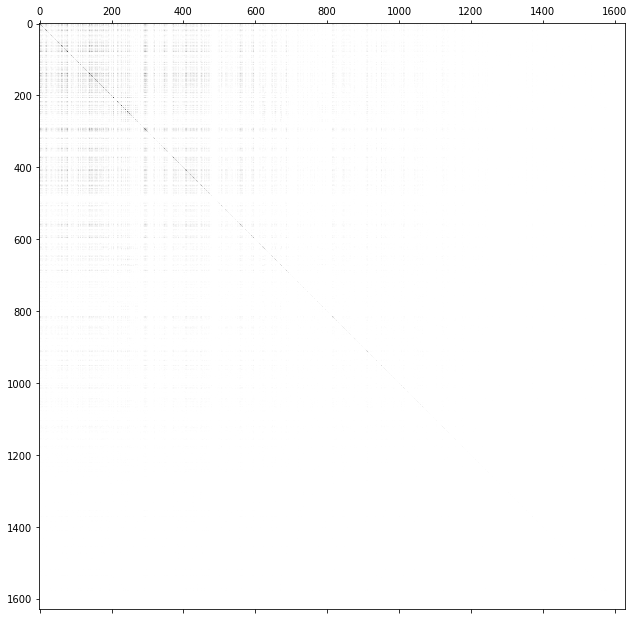

In [116]:
plt.matshow(coMatrix, fignum=1000, cmap=plt.cm.binary)
plt.gcf().set_size_inches(18.5, 10.5)
plt.show()

* Es muy spars (muchos ceros). 
* Se ve poco. Vamos a pasrla a logarítimca (para que diferencias grandes se atenúen y pueda ver algo mejor):


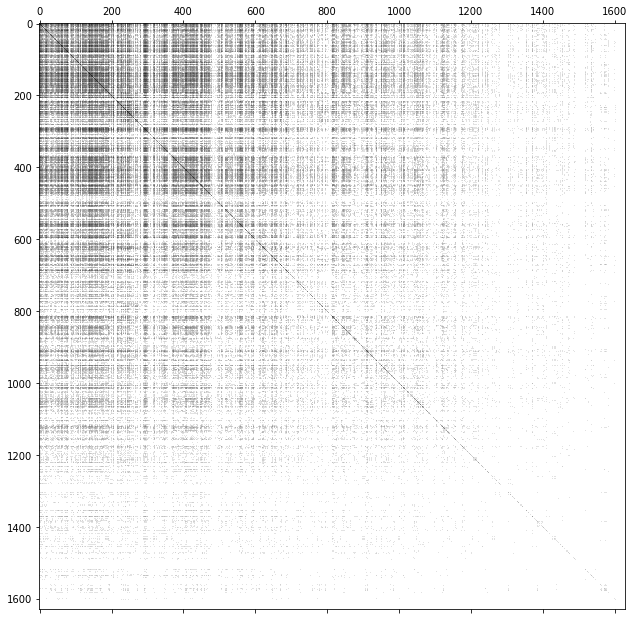

In [118]:
plt.matshow(np.log(coMatrix+1.0), fignum=1000, cmap=plt.cm.binary)
plt.gcf().set_size_inches(18.5, 10.5)
plt.show()

<div class="alert alert-success">
**QUESTION:** Can you think of a better way of visualizaing this matrix? Try to rescale it, or to rearrenge it follwoing some criteria (for instance, popularity!).
</div>

Para verlo más bonito, vamos a reordenarlo por popularidad. Lo tenemos por ejemplo en el modelo p. 

In [121]:
popular_indexing = p.model.index # aquí tengo los índices de película ordenadas por popularidad
popular_indexing

Int64Index([  36,   80,  207,  298,  251,  229,  230,  289,   99,  238,
            ...
            1512, 1515, 1524, 1516, 1517, 1309, 1308, 1522,  857, 1629],
           dtype='int64', name='item_id', length=1630)

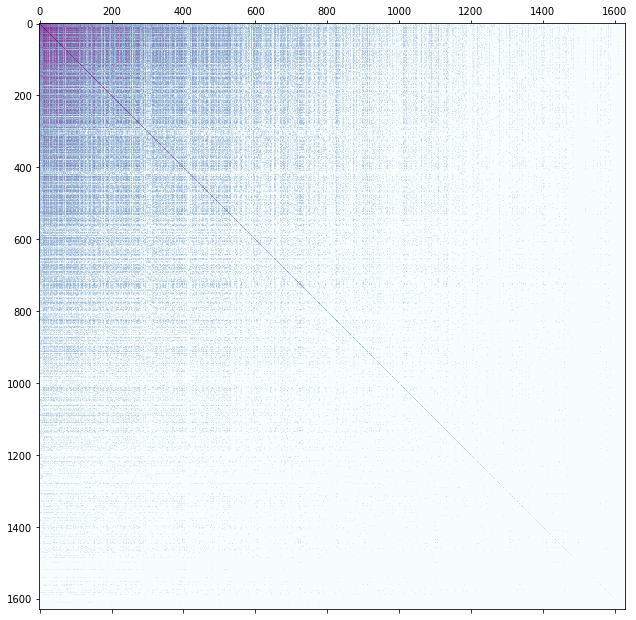

In [123]:

coMatrix_sorted = coMatrix[popular_indexing,:] # ordeno por filas
coMatrix_sorted_total = coMatrix_sorted[:, popular_indexing] # ordeno por columnas
log_scale = np.log(coMatrix_sorted_total+1.0)
plt.matshow(log_scale, fignum=1000, cmap=plt.cm.BuPu)
plt.gcf().set_size_inches(18.5, 10.5)
plt.show()

#### 4.1.1 Making predictions using the co-occurrence matrix

¿Cómo usamos esa matriz de concurrencia para hacer recomendaciones?

This kind of recommendations, based on item similarity, provide a measure of the closeness of one item to another. In order to make a recommendation for a user, we have to proceed as follows:

* First, define a function that returns the top-N closest items to a given one.
* Then, for a list of items adopted by a specific user, select the top-N items from the lists of top-N closest items to each adopted item.

El siguiente método, dada una peli, devuelve las similares a ésta ordenadas (está cogiendo una tira de la matriz), una fila/columna, según se vea, porque es simétrica)


In [126]:
def co_occurrance_similarity(item_id, coocurrance, ntop=10):
    """
    Returns the top-N most similar items to a given one, based on the coocurrance matrix
    
    :param item_id: id of input item
    :param cooccurrance: 2-dim numpy array with the co-occurance matrix
    :param ntop: number of items to be retrieved
    
    :return top-N most similar items to the given item_id
    """
    similarItems = coocurrance[item_id,:] # fila de freencuans de cada peli con mi peli. 
    # return indeces of most similar items in descendign order: use numpy argsort
    mostSimilar = np.argsort(similarItems)[::-1] # arg sort devuelve los índices que te ordenan el array. 
    # el -1 es para ponerlo descending, darle la vuelta al array. 
    # remove the first element, as it is the item itslef.Quitamos la qde más coorucrrencia, porque es ella misma
    mostSimilar = mostSimilar[1:ntop+1]
    
    # return a numpy array with the index (first column) and the value (second column) of the most similar items
    return np.stack((mostSimilar, similarItems[mostSimilar])).T

In [127]:
#TODO. Run the co_occurrance_similarity method
co_occurrance_similarity(49, coMatrix, 5)


array([[ 79., 124.],
       [140., 121.],
       [ 36., 118.],
       [139., 114.],
       [252., 111.]])

Interpretación: el 79 apareció 124 veces, el 140 apareció 121. Es decir, la película más "parecida" a la 49 es la 79. 

In [128]:
#TODO: Play with the movie ID, and print out its first Ntop recommendations!!
queryMovieId = 140
Ntop = 5
print('For item "%s" top-%s recommendations are:' % (movielens.unique_item_dict[queryMovieId], Ntop))

similarItems = co_occurrance_similarity(queryMovieId, coMatrix, Ntop)
# let's print out the first Ntop recommendations
for r in similarItems:
    print(int(r[0]), movielens.unique_item_dict[int(r[0])], r[1])

For item "b'Raiders of the Lost Ark (1981)'" top-5 recommendations are:
36 b'Star Wars (1977)' 193.0
139 b'Empire Strikes Back, The (1980)' 176.0
298 b'Return of the Jedi (1983)' 153.0
79 b'Silence of the Lambs, The (1991)' 152.0
62 b'Fugitive, The (1993)' 139.0


Viendolo un poco por encima, vemos que Start Wars aparece cadsi siempre. Eso es que claro, la popularidad pesa mucho. Si todo el mundo ve Start Wars, Star Wars se _parecerá_ a casi todas las películas

Now, let use this function to make recommendations:

Para una lista de pelis -(que serán las de un usuario), me creo una matriz, calculo lo de antes y lo voy concatenando abajo (como fila, de ahí vstrack)

In [147]:
def co_occurrance_recommendation(items_id, cooccurrance, ntop=10):
    """
    Obtain the list of ntop recommendations based on a list of items (user history of views)
    
    :param items_id: list of items ids
    :param coocurrence: co-ocurrence matrix (numpy 2-dim array)
    :param ntop: top-K items to be retrieved
    
    :return list of ntop items recommended
    """
    # another (row wise)
    list_sim_items = np.vstack([co_occurrance_similarity(id_, cooccurrance, ntop) for id_ in items_id])
    # Group by id and take the maximum frquency to remove duplicates
    largest_freq = pd.DataFrame(list_sim_items, columns=['id', 'freq']).groupby('id').agg(max).reset_index()
    
    # nota: si aquí, pusiera un min, podría hacer que entren algunos meonos populares, dentro de que ya tengo los 
    # n populares. 
    
    # sort by value in descending order
    sorted_list = largest_freq.sort_values(by='freq', ascending=False)
    
    # get the top N
    out = sorted_list.values[:ntop, 0]
    return out
    

Lo de arriba, para una lista de train, me devuelve las predicciones

Get the predictions (aka, recommendations)

Note that the predictions will be calculated for Ntop items. If you want the predictions for all the items, just set:

Ntop = movielens.n_items

Otherwise, choose your value. For instance:

Ntop = 200

The latter will be way faster.

In [143]:
# Ntop = movielens.n_items
Ntop = 200

In [ ]:
# use the dataframe trainUsersGrobuped and the method co_occurrance_recommendation
predictions = ?
predictions.head()

In [144]:
trainUsersGrouped.head().item_id.apply(lambda film_list: co_occurrance_recommendation(film_list,coMatrix,Ntop))

0    [298.0, 140.0, 36.0, 139.0, 80.0, 105.0, 79.0,...
1    [298.0, 140.0, 139.0, 80.0, 36.0, 105.0, 79.0,...
2    [36.0, 140.0, 79.0, 49.0, 139.0, 80.0, 447.0, ...
3    [298.0, 140.0, 139.0, 80.0, 105.0, 79.0, 289.0...
4    [36.0, 139.0, 140.0, 298.0, 79.0, 105.0, 62.0,...
Name: item_id, dtype: object

Versión para no perder índices (aunque no hace falta porque los tengo por ahí indezados). 

In [145]:
trainUsersGrouped.head().apply(lambda row: (row[0], co_occurrance_recommendation(row[1],coMatrix,Ntop)), axis=1)

0    (1, [298.0, 140.0, 36.0, 139.0, 80.0, 105.0, 7...
1    (2, [298.0, 140.0, 139.0, 80.0, 36.0, 105.0, 7...
2    (3, [36.0, 140.0, 79.0, 49.0, 139.0, 80.0, 447...
3    (4, [298.0, 140.0, 139.0, 80.0, 105.0, 79.0, 2...
4    (5, [36.0, 139.0, 140.0, 298.0, 79.0, 105.0, 6...
dtype: object

Ahora ya tenemos una recomendación personalizada. Es vierto que son los mismo items pero con un orden disntos en función dle usuario

Note that, unlike previous popularity based models, the recommendation is now (slightly) different from one user to another

#### Evalute the recommendation

Get the `recall_at_n` for several n

In [150]:
predictions_ids = trainUsersGrouped.item_id.apply(lambda film_list: co_occurrance_recommendation(film_list,coMatrix,Ntop))
topk = [5, 10, 20, 50]
predictions_ids = predictions.item_id.values
m = Metrics(train_ids, test_ids, predictions_ids)
_ = m.recall_at_n(topk)

KeyboardInterrupt: 

*Do the same analysis for the map metric*

In [ ]:
_ = m.map_at_n(topk)

<div class = "alert alert-info">
Compare this results to those obtained with the popularity model. Was it so bad?
</div>

Some comments:
* The dataset we are using here is very simple. Indeed, you can see that the popularity baseline achieves quite decent metric values. This won't happen in a real world dataset! The reason it happens here is because the dataset is quite small, and quite biased towards popular items. 

* Recall does not account for the order of the recommendation, while map does. This explains why the co-occurrance model performs better after the first 10 recommendations in terms of map (ordering), while recall values are always better for the popularity based model.  


### 4.1.2 Oher distances (lo dejó como ejercicio)

So far, we have defined the *closeness* of two items as the number of users shared. However, it would make make sense to define it relative the total number of users that have watch a movie. This can be done with the [Jaccard similarity index](https://en.wikipedia.org/wiki/Jaccard_index):

$$J(i,j)=\frac{|i\cap j|}{|i|+|j|-|i\cap j|}\in [0,1]$$


<div class = "alert alert-success">
Build the Jaccard similarity matrix from the co-occurrance matrix. Notice that $CoM(i,j) = |i\cap j|$ and $CoM(k,k) = |k|$. In addition, if both $|i|=0$ and $|j|=0$, the similarity is defined as 1 (this is a convention).
</div>

Define the Jaccard similarity matrix: jaccard

In [ ]:
jaccard = np.zeros((movielens.n_items, movielens.n_items)) # Jaccard similarity matrix
for i, row in enumerate(coMatrix):
    if row[i]!=0: # Case where the diagonal is not empty, i.e. coM(i,i)!=0
        jaccard[i,:] = ?
    else: # case where the diagonal is empty. We have to aasign a similarity of 1 to item pairs without ratings
        for j in np.arange(movielens.n_items):
            if coMatrix[j,j]==0:
                jaccard[i,j] = ?
            else: 
                jaccard[i,j] = ?

As before, let's visualize the matrix:

In [ ]:
plt.matshow(jaccard, fignum=1000, cmap=plt.cm.binary)
plt.gcf().set_size_inches(18.5, 10.5)
plt.show()

Rearrange following popularity criteria (avoid ones!):


In [ ]:
popularity = popularity_models('mostRated', movielens['train_set'])
popularity.train()
popular_indexing = popularity.model.index.values.astype(np.int)
jaccard_sorted = jaccard[:,popular_indexing]
jaccard_sorted_total = jaccard_sorted[popular_indexing, :]

# Remove ones:
jaccard_sorted_total[jaccard_sorted_total == 1.0] = 0.0
cax = plt.matshow(jaccard_sorted_total, fignum=1000, cmap=plt.cm.coolwarm)
plt.gcf().colorbar(cax, ticks=[0, 0.1, 0.2, 0.25])
plt.clim(0, 0.25)
plt.gcf().set_size_inches(18.5, 10.5)
plt.show()

Recommend using Jaccard similarity:

In [ ]:
Ntop = 200
# Calculate the predictoins with Jaccard
predictions = ?
predictions.head()

#### Evaluate the recommendations

In [ ]:
topk = [5, 10, 20, 50, 100]
predictions_ids = predictions.item_id.values
m = Metrics(train_ids, test_ids, predictions_ids)
_ = m.recall_at_n(topk)

In [ ]:
_ = m.map_at_n(topk)

<a id='memory-base'></a>
## 4.2. Memory-Based Collaborative Filtering (CF)

Hasta ahhora usábamos frecuencias de aparición. Ahora vamos a intentar ver similaridad entre items. ¿Cómo sé que dos items se parece? Pues por ejeplo, si ese item lo ven sólo el usuario paco, pepa y pepe, es que en algo se parecen, por ejemplo, que ellos son los actores y nol ve nadie más

En el fondo, si cogemos la la matriz de usuarios e items, es comparar vectore sde dentro de esa matriz.

Una forma normal es sacar el ángulo entre esos dos vectores. Conceptualmente es ver donde coinciden . 

la similaridad la puedo sacar de items o de usuarios (filas y coluimnas ). Además, lo peso con la popularidad que tenga ese item

El problema es que en un sistema normal, el tamaño de cada vector es de un millón. Estamos haciendo cálculos en un espacio de al menos un millón de dimensiones. 

Ademas, a medida que los vectores crecen, la probabilidad de que haya solape entre vectores es baja (hay 100000000 de películas, pero la gente no e 1000000, sino 1000, por tanto la probailidad de que en uno haya un1 y en le otro tb es del estilo a 1000/10000000 * 1000/10000000

Es como i yo intentará comprar pixel a pixel dos imágnes de 1Mpixel. Por ejemplo, compar dos imágenes de anclas,por ejemplo.

Otro ejemplo: texto. En un idioma hay en torno a 30000 palabras. Si intento com,prar palabra contra palabra, no hay solape.

Cualquier cosa con alta dimensionalidad, estamos jodidos. Una solución: depp learning. Esta es **la maldición de la dimensionalidad**

Although the methods developed so far return a list of recommended items, they cannot be used to make an actual prediction regarding the rating. A quite different approach would be to calculate the unknown rating, $r_{ui}$, as the averaged of some other ratings, thta are somehow close to either the user or the item in question. 

Thus, one approach is to take (basarme en la similaridad del item y otros)

### $$r_{u,i} = \frac{1}{K}\sum_{j\in\mathcal{I}'} \mathrm{sim}(i,j) r_{u,j},$$

where items $j\in\mathcal{I}'$ are taken from the set of $K$ closest items to $i$, or from the whole dataset. This is known as **item-item collaborative filtering**, and can be interpreted as *“users who liked this movie also liked …”*. See Amazon famous patent: https://www.google.com/patents/US7113917. Basically, this technique will take an item, find users who liked that item, and find other items that those users or similar users also liked. 

Similarly, one can define a **user-user filtering** where predictions are made as

### $$r_{u,i} = \frac{1}{K} \sum_{v\in\mathcal{U}'} \mathrm{sim}(u,v) r_{v,i}.$$

<img src="https://soundsuggest.files.wordpress.com/2013/06/utility_matrix.png" alt="utility matrix" style="float: right; width: 400px"/>

In this case, the recommendation would be more like *“users who are similar to you also liked …”*. Both techniques are part of the broad familiy of **Memory-Based Collaborative Filtering** approaches, or neighborhood-based algorithms.

The similarity among users or items can be calculated in a variety of forms: Pearson's correlation, cosine distance, etc. Here we will use the cosine distance. For this, we will first create the utility user-item matrix. 

The utility matrix is a dense representation of the user-item intearction. We have been using the *long* format, where missing entries are obviated; now, we will use the *wide* format, i.e. the matrix representation (see the figure on the right). 

<br></br>
<div class = "alert alert-info">
** NOTE **: Long and wide formats have its benefits and drawbacks. Can you think of some of them?
</div>

Put the train and test datasets in wide format (i.e., like a matrix). 

Name this variables uMatrixTraining and uMatrixTesting. 

Important!! Note user ids start at 1!

In [ ]:
uMatrixTraining = np.zeros((movielens.n_users, movielens.n_items)) # utility matrix
for row in movielens['train_set'].values[:,0:3]:
    # Note user ids start at 1
    ?

In [ ]:
uMatrixTesting = np.zeros((movielens.n_users, movielens.n_items)) # utility matrix
for row in movielens['test_set'].values[:,0:3]:
    # Note user ids start at 1
    ?

#### Define a similarity measure: cosine similarity

#### $$\mathrm{sim}({\bf a},{\bf b})=\frac{{\bf a}\cdot{\bf b}}{\sqrt{{\bf a}\cdot{\bf a}}\sqrt{{\bf  b}\cdot{\bf b}}}$$

In [ ]:
#TODO
def cosineSimilarity(ratings, kind='user', epsilon=1e-9):
    """
    Calculate the cosine distance along the row (columns) of a matrix for users (items)
    
    :param ratings: a n_user X n_items matrix
    :param kind: string indicating whether we are in mode 'user' or 'item'
    :param epsilon: a small value to avoid dividing by zero (optional, defaults to 1e-9)
    
    :return a square matrix with the similarities
    """
    # epsilon -> small number for handling dived-by-zero errors
    if kind == 'user':
        sim = ?
    elif kind == 'item':
        sim = ?
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return sim / norms / norms.T


### 4.2.1. User-user CF

*“Users who are similar to you also liked …”*

### $$r_{u,i} = \frac{1}{K} \sum_{v\in\mathcal{U}'} \mathrm{sim}(u,v) r_{v,i}.$$
Consider user $x$:

1. Find other users whose ratings are “similar” to $x$’s ratings, i.e. calculate the similarity among users with the help of the cosineSimilarity function.
2. Estimate missing ratings based on ratings of similar users

In [ ]:
userSimilarity = cosineSimilarity(uMatrixTraining, kind='user')

Have a look at the userSimilarity matrix:

In [ ]:
cax = plt.matshow(userSimilarity, fignum=1000, cmap=plt.cm.coolwarm)
plt.gcf().colorbar(cax, ticks=[0, 0.25, 0.5])
plt.clim(0, 0.5)
plt.gcf().set_size_inches(18.5, 10.5)
plt.show()

Now, get userItemCFpredictions

*Note that if we multiply `userSimilarity` by `uMatrixTraining` we get the ratings weigthed with user similar similarity. Then, we have to normalize by the average similarity for each user*

In [ ]:
norm = np.array([userSimilarity.sum(axis=1)]).T
userItemCFpredictions = userSimilarity.dot(uMatrixTraining) / norm

*Note that some users might give generally lower ratings than others, so that we could have also corrected for this effect as follows*

In [ ]:
sum_ = uMatrixTraining.sum(axis=1)
len_ =np.count_nonzero(uMatrixTraining, axis=1)
average_ratings = np.tile(sum_/ len_, movielens.n_items).reshape([movielens.n_items, movielens.n_users]).T
uMatrixTraining_shifted = uMatrixTraining - np.multiply(average_ratings, uMatrixTraining)
userItemCFpredictions_corrected = average_ratings + userSimilarity.dot(uMatrixTraining_shifted) / norm

### 4.2.2. Item-Item CF

*“Users who liked this movie also liked …”*

Consider item $i$, and following the previous section:

1. For item $i$, find other similar items, i.e. calculate the similarity itemSimilarity among items as before we did for users
2. Estimate rating for item $i$ based on ratings for similar items: itemItemCFpredictions



In [ ]:
itemSimilarity = cosineSimilarity(uMatrixTraining, kind='item')

In [ ]:
itemItemCFpredictions = uMatrixTraining.dot(itemSimilarity)/np.array([np.abs(itemSimilarity).sum(axis=1)])

### 4.2.3 Show some recommendations

In case of item-item CF, the recommendation is pretty much the same as with the co-occurence matrix. It's also quite simple to find similar items to a given one.

Find movies similar to a given one using the item-item similarity matrix.



In [ ]:
queryMovieId = 720
print("Selected item is '%s'" % movielens.unique_item_dict[queryMovieId])


queryAnswer = itemSimilarity[queryMovieId,:]
queryAnswer = np.argsort(queryAnswer)[::-1] #descending order
queryAnswer = queryAnswer[1:]  # remove first item (itself)

# let's print out the most similar items
Ntop = 10
print("Most %d similar movies are:" %Ntop)
printAnswer = queryAnswer[0:Ntop]
for answerId in printAnswer:
    print(movielens.unique_item_dict[answerId]+", with similarity %.2f" %itemSimilarity[queryMovieId, answerId])

Calculate the recommendations obtained with the item-item CF model.


In [ ]:
itemItemCFpredictions[uMatrixTraining>=4.0] = 0.0
for u in np.random.randint(0, movielens.n_users, 3):
    print("*"*6)
    print("User %s" % u)
    print("Seen items: ")
    seen = uMatrixTesting[u,:]
    print([movielens.unique_item_dict[i] for i,r in enumerate(seen) if r>4.0])
    print("Recommended items: ")
    recom = itemItemCFpredictions[u,:]
    recom = np.argsort(recom)[::-1][:10]
    print([movielens.unique_item_dict[i] for i in recom])

<div class="alert alert-success">
Do the same with the user-user CF model.
</div>

In [ ]:
userItemCFpredictions[uMatrixTraining>=4.0] = 0.0
userItemCFpredictions_corrected[uMatrixTraining>=4.0] = 0.0
for u in np.random.randint(0, movielens.n_users, 3):
    print("*"*6)
    print("User %s" % u)
    print("Seen items: ")
    seen = uMatrixTesting[u,:]
    print([movielens.unique_item_dict[i] for i,r in enumerate(seen) if r>4.0])
    print("Recommended items: ")
    recom = userItemCFpredictions[u,:]
    recom = np.argsort(recom)[::-1][:10]
    print([movielens.unique_item_dict[i] for i in recom])
    print("Recommended items (shifted version): ")
    recom = userItemCFpredictions_corrected[u,:]
    recom = np.argsort(recom)[::-1][:10]
    print([movielens.unique_item_dict[i] for i in recom])

**As you can see, the recommendations are pretty bad... Let's measure that**

### 4.2.4 Measure the recommendations

Since we are predicting ratings, it might make sense to introduce a metric that accounts for this. In particular, the **Root Mean Square Error (RMSE)** is typically used for this purpose. 

### $$\mathrm{RMSE}=\sqrt{\frac{1}{n_{\mathrm{users}}n_{\mathrm{items}}}\sum_{u,i}\left(r_{u,i}-\hat{r}_{u,i}\right)^2}$$

In [ ]:
#TODO
from math import sqrt
def rmse(prediction, ground_truth):
    """
    Return the Root Mean Squared Error of the prediction
    
    :param prediction: a 2-dim numpy array with the predictions
    :param ground_truth: a 2-dim numpy array with the known ratings
    
    :return the RMSE
    """
    # get indices of non-zero elements at test
    r, c = ground_truth.nonzero()
    # get non-zero elements at prediction
    p = prediction[r,c]
    # get non-zero elements at test
    t = ground_truth[r,c]
    return sqrt(np.mean(np.power(p-t, 2.0)))

In [ ]:
print('User-based CF RMSE=%.3f' %rmse(userItemCFpredictions, uMatrixTesting))

In [ ]:
print('Item-based CF RMSE=%.3f' %rmse(itemItemCFpredictions, uMatrixTesting))

### Calculate ranking metrics

In [ ]:
# get all the recommendations
userItemCFpredictions_sorted = np.argsort(userItemCFpredictions)[::-1]
# get the first 200, to speed up things
userItemCFpredictions_sorted = userItemCFpredictions_sorted[:, :200]

test_ids = testUsersGrouped.item_id.values
train_ids = trainUsersGrouped.item_id.values
predicted_ids = trainUsersGrouped.user_id.apply(lambda i: userItemCFpredictions_sorted[i-1]).values
topk = [5, 10, 20, 50, 100]
m = Metrics(train_ids, test_ids, predicted_ids)
print('*****Recall*****')
_ = m.recall_at_n(topk)
print('*****Map*****')
_ = m.map_at_n(topk)



<a id='model-base'></a>
## 4.3. Model-based CF or Latent factor models

Copio de nuevo de arriba:

El problema es que en un sistema normal, el tamaño de cada vector es de un millón. Estamos haciendo cálculos en un espacio de al menos un millón de dimensiones. 

Ademas, a medida que los vectores crecen, la probabilidad de que haya solape entre vectores es baja (hay 100000000 de películas, pero la gente no e 1000000, sino 1000, por tanto la probailidad de que en uno haya un1 y en le otro tb es del estilo a 1000/10000000 * 1000/10000000

Es como i yo intentará comprar pixel a pixel dos imágnes de 1Mpixel. Por ejemplo, compar dos imágenes de anclas,por ejemplo.

Otro ejemplo: texto. En un idioma hay en torno a 30000 palabras. Si intento com,prar palabra contra palabra, no hay solape.

Cualquier cosa con alta dimensionalidad, estamos jodidos. Una solución: depp learning. Esta es **la maldición de la dimensionalidad**

Tenemos que ser capaces de "comprimir" esos vectores/matrices, por ejemplo mediante un hash. PEro hay otros. Ellos son por ejemplo SVD y ALS. Son algoritmos de reducción de dimensiaonalidad

Estaría bien que si yo tuviera un vector que representar a un usuario y otro que reperentara a un item y si los multiplicase me saliera la predicción. A esto se dedica.

There are several model-based CF: from matrix factorizations to bayesian models, neural netwroks, etc. In all of them, we try to extract latent factors (vectors) that model user and item interactions. In contrast to previous methods, our hypothesis here is that the dimension of the latent spaces is rather small (in the order of a hundred dimensions). Then, we use this latent features to make a prediction:

## $$r_{u,i} \approx {\bf f}_u^T\cdot{\bf f}_i$$

The underlying assumption is that both users and items *live* in the same latent space, and that we can unravel such space. 

<img src="https://www.researchgate.net/profile/Tunca_Dogan/publication/235913413/figure/fig3/AS:299678856957952@1448460415040/Figure-3-The-distribution-of-the-points-in-the-Swiss-roll-dataset-in-3-D-space.png
" alt="swiss roll" style="float: center; width: 300px"/>


Here we will use a couple of linear Matrix Factorization (MF) models:

* Singular Value decomposition (SVD)
* Alternating Least Squares (ALS)

### 4.3.1 Singular value decomposition

The main idea is to reduce the dimensionality of the input space. This is pretty much the same as Eigen-decomposition or Principal Component Analysis (PCA)-

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f5/GaussianScatterPCA.svg/220px-GaussianScatterPCA.svg.png
" alt="dimensionaly reducion" style="float: center; width: 500px"/>


La imagen tan compljea de arriba la puedo simplificar simplemente diciendo la dirección y la anchura (de una super matriz he pasdao a dos propiedades

Lo que hacemos es descomponete la matriz de usuarios y peñículas por lamuñtiplicación de una matriz de usuario por otra de peliculas. Además lo usamos con un factor K, que hace queme comprima datos. 

En este caso k = 2

al autmentar K puede llegar un punto en el que empieza a aparnder el ruido. En este caso del mercurio, la segunda compoente ya es ruido


Con eso, para hacer una predicción sólo tenemos que multilpicar un vector dela matriz U por otro de la matriz P y me saldŕa la predcción de una peñi para un usuario

![remember](https://www.jeremyjordan.me/content/images/2017/07/Screen-Shot-2017-07-21-at-2.30.04-PM.png)

In [153]:
from scipy.sparse.linalg import svds

Get SVD components from train matrix. Choose k=20.


Generamos uMatrixTreaingn que estbaa arriba sin hacer

In [151]:
uMatrixTraining = np.zeros((movielens.n_users, movielens.n_items)) # utility matrix
for row in movielens['train_set'].values[:,0:3]:
    # Note user ids start at 1
    uid = row[0]-1
    iid = row[1]
    rat = row[2]
    uMatrixTraining[uid,iid] = rat

In [152]:
k=20
u, s, vt = svds(uMatrixTraining, k)

NameError: name 'svds' is not defined

Take a look at the different matrices
* check the shapes
* check if U and V are orthogonal matrices with the left singular vectors as columns

In [ ]:
print(u.shape)
# Check U is orthogonal
print(rmse(np.dot(u.T,u), np.identity(k)))


In [ ]:
# Same with V
print(vt.shape)
print(rmse(np.dot(vt,vt.T), np.identity(k)))

### Get the recommendations

We will reconstruct the utility matrix R (i.e., the recommendation matrix) as follows:

### $$M\approx U\mathrm{diag}(s)V^T$$

First, build a diagonal matrix s_diag_matrix with the eigenvalues




In [ ]:
s_diag_matrix = np.diag(s)

Make the prediction: svdPredictions

In [ ]:
svdPredictions = np.dot(np.dot(u, s_diag_matrix), vt)

Check if the dimensions of svdPredictions and uMatrixTesting are correct

In [ ]:
print(svdPredictions.shape)
print(uMatrixTesting.shape)

### Evaluate the model

* Recall@{10,100}
* Play with more dimensions: svd_dim in {10, 50, 100}

In [ ]:
print('SVD RMSE=%.3f' % rmse(svdPredictions, uMatrixTesting))

In [ ]:
# recall
svdPredictions_sorted = np.argsort(svdPredictions)[::-1]
svdPredictions_sorted = svdPredictions_sorted[:, :200]
test_ids = testUsersGrouped.item_id.values
predicted_ids = trainUsersGrouped.user_id.apply(lambda i: svdPredictions_sorted[i-1]).values
topk = [10, 20, 50, 100]
m = Metrics(train_ids, test_ids, predicted_ids)
print('*****Recall*****')
_ = m.recall_at_n(topk)
print('*****Map*****')
_ = m.map_at_n(topk)

In [ ]:
for dim in [10, 50, 100]:
    print("*"*30)
    print("Using %s latent dimensions" %dim)
    # apply Singular Value Decomposition
    u, s, vt = svds(uMatrixTraining, dim)
    s_diag_matrix = np.diag(s)
    # make the prediction
    svdPredictions = np.dot(np.dot(u, s_diag_matrix), vt)
    print('SVD RMSE=%.3f' % rmse(svdPredictions, uMatrixTesting))
    # recall
    svdPredictions_sorted = np.argsort(svdPredictions)[::-1]
    svdPredictions_sorted = svdPredictions_sorted[:, :200]
    
    test_ids = testUsersGrouped.item_id.values
    predicted_ids = trainUsersGrouped.user_id.apply(lambda i: svdPredictions_sorted[i-1]).values
    topk = [5, 10, 20, 50, 100]
    m = Metrics(train_ids, test_ids, predicted_ids)
    print('*****Recall*****')
    _ = m.recall_at_n(topk)
    print('*****Map*****')
    _ = m.map_at_n(topk)

### Implicit vs Explicit feedback

In the above SVD matrix factorization we have tried to reconstructt the matrix of ratings. However, it might be easier trying to model the matrix of preferences (i.e., wether the user likes or not a movie).

For this, we will define a “selector” matrix $I$ for the training utility matrix $R$, which will contain 0 if the rating matrix has no rating entry, and 1 if the rating matrix contains an entry. And the smae for testing data.


Convert uMatrixTraining and uMatrixTesting into implicit data (I and I2 respectively). For these new matrices, if r>3 then 1, else = 0

In [ ]:
# Index matrix for training data
I = uMatrixTraining.copy()
I[I > 3] = 1
I[I == 0] = 0

In [ ]:
# Index matrix for test data
I2 = uMatrixTesting.copy()
I2[I2 > 3] = 1
I2[I2 == 0] = 0

Evaluate SVD with RMSE, and recall@k and map@k, with k in [10, 30, 50, 100]

In [ ]:
for dim in [50]:
    print("*"*30)
    print("Using %s latent dimensions" %dim)
    # apply Singular Value Decomposition
    u, s, vt = svds(I, dim)
    s_diag_matrix = np.diag(s)
    # make the prediction
    svdPredictions = np.dot(np.dot(u, s_diag_matrix), vt)
    print('SVD RMSE=%.3f' % rmse(svdPredictions, I2))
    # recall
    svdPredictions_sorted = np.argsort(svdPredictions)[::-1]
    svdPredictions_sorted = svdPredictions_sorted[:, :200]
    test_ids = testUsersGrouped.item_id.values
    predicted_ids = trainUsersGrouped.user_id.apply(lambda i: svdPredictions_sorted[i-1]).values
    topk = [10, 50, 100]
    m = Metrics(train_ids, test_ids, predicted_ids)
    print('*****Recall*****')
    _ = m.recall_at_n(topk)
    print('*****Map*****')
    _ = m.map_at_n(topk)

### Overfitting

As we introduce more dimensions in the model, we make it more prone to overfit. This can be observed in the decrease of error (RMSE) in train, while it increases in test.

In [ ]:
error_train = []
error_test = []
dims = [2, 5, 10, 20, 40, 80, 200]
for dim in dims:
    print("*"*30)
    print("Using %s latent dimensions" %dim)
    # apply Singular Value Decomposition
    u, s, vt = svds(I, dim)
    s_diag_matrix = np.diag(s)
    # make the prediction
    svdPredictions = np.dot(np.dot(u, s_diag_matrix), vt)
    error_train.append(rmse(svdPredictions, I))
    error_test.append(rmse(svdPredictions, I2)) 
plt.semilogx(dims, error_train, '--*b', label="train")
plt.semilogx(dims, error_test, '--*g', label="test")
plt.xlabel("Numer of latent dimensions")
plt.ylabel("Error")
plt.legend(loc=7)
plt.show()

**Note that after few dimensions (~10) the model starts to overfit (the error in test increases). Thus, we need to use other method to regularize the model (i.e., set restrictions/limitations to the model, so that it cannot overfit)**

### 3.2 Alternating Least Squares (ALS)

SVD can be very slow and computationally expensive. Besides, when addressing only the relatively few known entries we are highly prone to overfitting.

An scalable alternative to SVD is ALS, which can include regularization terms to prevent overfitting. We will rename our variable to make them more similar to the ALS notation

### ALS algorithm

The ALS algorithm aims to estimate two unknown matrices which, when multiplied together, yield the rating matrix. The loss function you will use is the well-known sum of squared errors. The second term is for regularisation to prevent overfitting

<img src="https://latex.codecogs.com/gif.latex?\underset{Q*&space;,&space;P*}{min}\sum_{(u,i)\epsilon&space;K&space;}(r_{ui}-P_u^TQ_i)^2&plus;\lambda(\left&space;\|&space;Q_i&space;\right&space;\|^2&space;&plus;&space;\left&space;\|&space;P_u&space;\right&space;\|^2)$&space;&space;$" title="\underset{q* , p*}{min}\sum_{(u,i)\epsilon K }(r_{ui}-q_i^Tp_u)^2+\lambda(\left \| q_i \right \|^2 + \left \| p_u \right \|^2)" />

The Alternating Least Squares algorithm does this by first randomly filling the users matrix with values and then optimizing the value of the movies such that the error is minimized.  Then, it holds the movies matrix constant and optimizes the value of the user's matrix.  This alternation between which matrix to optimize is the reason for the "alternating" in the name. 

<img alt="factorization" src="http://spark-mooc.github.io/web-assets/images/matrix_factorization.png" style="width: 885px"/>
<br clear="all"/>

This optimization is what's being shown on the right in the image above.  Given a fixed set of user factors (i.e., values in the users matrix), we use the known ratings to find the best values for the movie factors using the optimization written at the bottom of the figure.  Then we "alternate" and pick the best user factors given fixed movie factors.

It must be noticed that this is another way of reducing the dimensionality of the input matrix (like PCA, or more generally, SVD). This has important consequences:

* ### Our decomposition is linear. We won't be able to catch non-linear relationships among users and items.
* ### As in PCA or SVD, our features will correspond to directions of maximum variance in the data. Thus, the first feature will catch most of this variation, the second, a little bit more, and so on. It implies that the error in the reconstruction will not decrease dramatically when using more features!!! Keep this in mind.


In [ ]:
def alsRmse(I,R,P,Q):
    return np.sqrt(np.sum((I * (R - np.dot(P,Q.T)))**2)/len(R[R > 0]))

In [ ]:
import time
def iteration(user, fixed_vecs, counts, num_factors, reg_param, num_solve, verbose=False):
    num_fixed = fixed_vecs.shape[0]
    YTY = fixed_vecs.T.dot(fixed_vecs)
    eye = np.eye(num_fixed)
    lambda_eye = reg_param * np.eye(num_factors)
    solve_vecs = np.zeros((num_solve, num_factors))

    t = time.time()
    for i in range(num_solve):
        if user:
            counts_i = counts[i]
        else:
            counts_i = counts[:, i].T
        CuI = np.diag(counts_i)
        pu = counts_i.copy()
        pu[np.where(pu != 0)] = 1.0
        YTCuIY = fixed_vecs.T.dot(CuI).dot(fixed_vecs)
        YTCupu = fixed_vecs.T.dot(CuI + eye).dot(pu.T)
        xu = np.linalg.solve(YTY + YTCuIY + lambda_eye, YTCupu)
        solve_vecs[i] = xu
        if verbose and i % 300 == 0:
            print('Solved %i vecs in %d seconds' % (i, time.time() - t))
            t = time.time()

    return solve_vecs

In [ ]:
# Check performance by plotting train and test errors
import matplotlib.pyplot as plt
%matplotlib inline

def check_als_performance(n_epochs, train_errors, test_errors):
    plt.plot(range(n_epochs), train_errors, marker='o', label='Training Data');
    plt.plot(range(n_epochs), test_errors, marker='v', label='Test Data');
    plt.title('ALS-WR Learning Curve')
    plt.xlabel('Number of Epochs');
    plt.ylabel('RMSE');
    plt.ylim(1, 5)
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
num_iterations = 10
num_factors = 50
lmbda = 0.2  # this hyperparameter controlls the regularization. Play wiht it!
T = uMatrixTesting.copy()
ptest = uMatrixTesting.copy()
ptest[ptest > 0] = 1
ptest[ptest == 0] = 0
p = uMatrixTraining.copy()
p[p > 0] = 1
p[p == 0] = 0
R = uMatrixTraining.copy()
alpha = movielens.n_pairs / (movielens.n_users * movielens.n_items)
C = alpha * R
user_vectors = np.random.normal(size=(movielens.n_users, num_factors))
item_vectors = np.random.normal(size=(movielens.n_items, num_factors))
train_errors = []
test_errors = []
for i in range(num_iterations):
    print('Solving for user vectors...')
    user_vectors = iteration(True, item_vectors, C, num_factors, lmbda, movielens.n_users)
    print('Solving for item vectors...')
    item_vectors = iteration(False, user_vectors, C, num_factors, lmbda, movielens.n_items)
    print('iteration %i finished' % (i + 1))
    
    train_rmse = alsRmse(p,uMatrixTraining, user_vectors,item_vectors)
    test_rmse = alsRmse(ptest,uMatrixTesting, user_vectors,item_vectors)
    train_errors.append(train_rmse)
    test_errors.append(test_rmse)
    print("[Epoch %d/%d] train error: %f, test error: %f" 
        %(i+1, num_iterations, train_rmse, test_rmse))
    
print("Algorithm converged")



In [ ]:
check_als_performance(num_iterations, train_errors, test_errors)

### ALS evaluation
* RMSE
* recall@
* map@

In [ ]:
alsPredictions = np.dot(user_vectors, item_vectors.T)
svdPredictions = np.dot(np.dot(u, s_diag_matrix), vt)
print('ALS CF RMSE: ' + str(rmse(alsPredictions, uMatrixTesting)))
print('SVD CF RMSE: ' + str(rmse(svdPredictions, uMatrixTesting)))

In [ ]:
# evalutation
topk = [20, 50, 100]
alsPredictions_sorted = np.argsort(alsPredictions)[::-1]
alsPredictions_sorted = alsPredictions_sorted[:, :np.max(topk)]
predicted_ids = trainUsersGrouped.user_id.apply(lambda i: alsPredictions_sorted[i-1]).values
m = Metrics(train_ids, test_ids, predicted_ids)
print('*****Recall*****')
_ = m.recall_at_n(topk)
print('*****Map*****')
_ = m.map_at_n(topk)